# Novel class segmentation demo with Deep-MAC

Welcome to the Novel class segmentation (with Deep-MAC) demo --- this colab loads a Deep-MAC model and tests it interactively with user-specified boxes. Deep-MAC was only trained to detect and segment COCO classes, but generalizes well when segmenting within user-specified boxes of unseen classes.

Estimated time to run through this colab (with GPU): 10-15 minutes.
Note that the bulk of this time is in installing Tensorflow and downloading
the checkpoint then running inference for the first time.                Once you've done
all that, running on new images is very fast.

# Prerequisites

Please change runtime to GPU.

# Installation and Imports

This takes 3-4 minutes.

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
                while "models" in pathlib.Path.cwd().parts:
                                os.chdir('..')
elif not pathlib.Path('models').exists():
                !git clone --depth 1 https://github.com/tensorflow/models


     |████████████████████████████████| 516.2 MB 4.6 kB/s 
     |████████████████████████████████| 454 kB 37.5 MB/s 
     |████████████████████████████████| 3.0 MB 41.7 MB/s 
     |████████████████████████████████| 2.9 MB 43.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1661033 sha256=bfe9966e80a0d75593422cda0106b892a58fce736fefd8055e9efc80c1544428
  Stored in directory: /tmp/pip-ephem-wheel-cache-128e0dt2/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=8834d698354b9ae6a2ba65e090942cc16b4f56e8baf668e8eb106b9b2ccd97d9
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=8abfd4c169d46d380d7e782a456ea9ab8ddf0791b46741b9c6a062b414ef0f6d
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=30a6c15b005db80ddf2c282825f28537cc9e67f369c13947c

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import glob
import io
import logging
import os
import random
import warnings

import imageio
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from object_detection.utils import colab_utils
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz_utils
from PIL import Image, ImageDraw, ImageFont
import scipy.misc
from six import BytesIO
from skimage import color
from skimage import transform
from skimage import util
from skimage.color import rgb_colors
import tensorflow as tf

%matplotlib inline

COLORS = ([rgb_colors.cyan, rgb_colors.orange, rgb_colors.pink,
                                                                                 rgb_colors.purple, rgb_colors.limegreen , rgb_colors.crimson] +
                                                                                [(color) for (name, color) in color.color_dict.items()])
random.shuffle(COLORS)

logging.disable(logging.WARNING)


def read_image(path):
                                """Read an image and optionally resize it for better plotting."""
                with tf.io.gfile.GFile(path, 'rb') as f:
                                img = Image.open(f)
                                return np.array(img, dtype=np.uint8)


def resize_for_display(image, max_height=600):
                height, width, _ = image.shape
                width = int(width * max_height / height)
                with warnings.catch_warnings():
                                warnings.simplefilter("ignore", UserWarning)
                                return util.img_as_ubyte(transform.resize(image, (height, width)))


def get_mask_prediction_function(model):
                """Get single image mask prediction function using a model."""

                @tf.function
                def predict_masks(image, boxes):
                                height, width, _ = image.shape.as_list()
                                batch = image[tf.newaxis]
                                boxes = boxes[tf.newaxis]

                                detections = model(batch, boxes)
                                masks = detections['detection_masks']

                                return ops.reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                                                                                                                                                                                                                                                                                                                                                                                height, width)

                return predict_masks


def plot_image_annotations(image, boxes, masks, darken_image=0.5):
                fig, ax = plt.subplots(figsize=(16, 12))
                ax.set_axis_off()
                image = (image * darken_image).astype(np.uint8)
                ax.imshow(image)

                height, width, _ = image.shape

                num_colors = len(COLORS)
                color_index = 0

                for box, mask in zip(boxes, masks):
                                ymin, xmin, ymax, xmax = box
                                ymin *= height
                                ymax *= height
                                xmin *= width
                                xmax *= width

                                color = COLORS[color_index]
                                color = np.array(color)
                                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                                                                                                                                                                                                 linewidth=2.5, edgecolor=color, facecolor='none')
                                ax.add_patch(rect)
                                mask = (mask > 0.5).astype(np.float32)
                                color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
                                color_and_mask = np.concatenate(
                                                                [color_image, mask[:, :, np.newaxis]], axis=2)

                                ax.imshow(color_and_mask, alpha=0.5)

                                color_index = (color_index + 1) % num_colors

                return ax

In [ ]:

def read_image(path):
        """Read an image and optionally resize it for better plotting."""
        with open(path, 'rb') as f:
                img = Image.open(f)
                return np.array(img, dtype=np.uint8)

def read_json(path):
        with open(path) as f:
                return json.load(f)

def create_detection_map(annotations):
        """Creates a dict mapping IDs to detections."""

        ann_map = {}
        for image in annotations['images']:
                ann_map[image['id']] = image['detections']
        return ann_map

def get_mask_prediction_function(model):
        """Get single image mask prediction function using a model."""

        @tf.function
        def predict_masks(image, boxes):
                height, width, _ = image.shape.as_list()
                batch = image[tf.newaxis]
                boxes = boxes[tf.newaxis]

                detections = model(batch, boxes)
                masks = detections['detection_masks']

                return reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                                                                                                                                                                 height, width)

        return predict_masks

def convert_boxes(boxes):
        xmin, ymin, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        ymax = ymin + height
        xmax = xmin + width

        return np.stack([ymin, xmin, ymax, xmax], axis=1).astype(np.float32)

In [ ]:
# Copied from tensorflow/models
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                                                         image_width, resize_method='bilinear'):
    """Transforms the box masks back to full image masks.
    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.
    Args:
        box_masks: A tensor of size [num_masks, mask_height, mask_width].
        boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
                     corners. Row i contains [ymin, xmin, ymax, xmax] of the box
                     corresponding to mask i. Note that the box corners are in
                     normalized coordinates.
        image_height: Image height. The output mask will have the same height as
                                    the image height.
        image_width: Image width. The output mask will have the same width as the
                                 image width.
        resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
            'bilinear' is only respected if box_masks is a float.
    Returns:
        A tensor of size [num_masks, image_height, image_width] with the same dtype
        as `box_masks`.
    """
    resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
    # TODO(rathodv): Make this a public function.
    def reframe_box_masks_to_image_masks_default():
        """The default function when there are more than 0 box masks."""
        def transform_boxes_relative_to_boxes(boxes, reference_boxes):
            boxes = tf.reshape(boxes, [-1, 2, 2])
            min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
            max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
            denom = max_corner - min_corner
            # Prevent a divide by zero.
            denom = tf.math.maximum(denom, 1e-4)
            transformed_boxes = (boxes - min_corner) / denom
            return tf.reshape(transformed_boxes, [-1, 4])

        box_masks_expanded = tf.expand_dims(box_masks, axis=3)
        num_boxes = tf.shape(box_masks_expanded)[0]
        unit_boxes = tf.concat(
                [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
        reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)

        # TODO(vighneshb) Use matmul_crop_and_resize so that the output shape
        # is static. This will help us run and test on TPUs.
        resized_crops = tf.image.crop_and_resize(
                image=box_masks_expanded,
                boxes=reverse_boxes,
                box_indices=tf.range(num_boxes),
                crop_size=[image_height, image_width],
                method=resize_method,
                extrapolation_value=0)
        return tf.cast(resized_crops, box_masks.dtype)

    image_masks = tf.cond(
            tf.shape(box_masks)[0] > 0,
            reframe_box_masks_to_image_masks_default,
            lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
    return tf.squeeze(image_masks, axis=3)

def plot_image_annotations(image, boxes, masks, darken_image=0.5):
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_axis_off()
    image = (image * darken_image).astype(np.uint8)
    ax.imshow(image)

    height, width, _ = image.shape

    num_colors = len(COLORS)
    color_index = 0

    for box, mask in zip(boxes, masks):
        ymin, xmin, ymax, xmax = box
        ymin *= height
        ymax *= height
        xmin *= width
        xmax *= width

        color = COLORS[color_index]
        color = np.array(color)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                         linewidth=2.5, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        mask = (mask > 0.5).astype(np.float32)
        color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
        color_and_mask = np.concatenate(
                [color_image, mask[:, :, np.newaxis]], axis=2)

        ax.imshow(color_and_mask, alpha=0.5)

        color_index = (color_index + 1) % num_colors

    return ax

In [ ]:

# Copied from tensorflow/models
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                                                         image_width, resize_method='bilinear'):
    """Transforms the box masks back to full image masks.
    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.
    Args:
        box_masks: A tensor of size [num_masks, mask_height, mask_width].
        boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
                     corners. Row i contains [ymin, xmin, ymax, xmax] of the box
                     corresponding to mask i. Note that the box corners are in
                     normalized coordinates.
        image_height: Image height. The output mask will have the same height as
                                    the image height.
        image_width: Image width. The output mask will have the same width as the
                                 image width.
        resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
            'bilinear' is only respected if box_masks is a float.
    Returns:
        A tensor of size [num_masks, image_height, image_width] with the same dtype
        as `box_masks`.
    """
    resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
    # TODO(rathodv): Make this a public function.
    def reframe_box_masks_to_image_masks_default():
        """The default function when there are more than 0 box masks."""
        def transform_boxes_relative_to_boxes(boxes, reference_boxes):
            boxes = tf.reshape(boxes, [-1, 2, 2])
            min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
            max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
            denom = max_corner - min_corner
            # Prevent a divide by zero.
            denom = tf.math.maximum(denom, 1e-4)
            transformed_boxes = (boxes - min_corner) / denom
            return tf.reshape(transformed_boxes, [-1, 4])

        box_masks_expanded = tf.expand_dims(box_masks, axis=3)
        num_boxes = tf.shape(box_masks_expanded)[0]
        unit_boxes = tf.concat(
                [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
        reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)

        # TODO(vighneshb) Use matmul_crop_and_resize so that the output shape
        # is static. This will help us run and test on TPUs.
        resized_crops = tf.image.crop_and_resize(
                image=box_masks_expanded,
                boxes=reverse_boxes,
                box_indices=tf.range(num_boxes),
                crop_size=[image_height, image_width],
                method=resize_method,
                extrapolation_value=0)
        return tf.cast(resized_crops, box_masks.dtype)

    image_masks = tf.cond(
            tf.shape(box_masks)[0] > 0,
            reframe_box_masks_to_image_masks_default,
            lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
    return tf.squeeze(image_masks, axis=3)

def plot_image_annotations(image, boxes, masks, darken_image=0.5):
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_axis_off()
    image = (image * darken_image).astype(np.uint8)
    ax.imshow(image)

    height, width, _ = image.shape

    num_colors = len(COLORS)
    color_index = 0

    for box, mask in zip(boxes, masks):
        ymin, xmin, ymax, xmax = box
        ymin *= height
        ymax *= height
        xmin *= width
        xmax *= width

        color = COLORS[color_index]
        color = np.array(color)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                         linewidth=2.5, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        mask = (mask > 0.5).astype(np.float32)
        color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
        color_and_mask = np.concatenate(
                [color_image, mask[:, :, np.newaxis]], axis=2)

        ax.imshow(color_and_mask, alpha=0.5)

        color_index = (color_index + 1) % num_colors

    return ax

# Load Deep-MAC Model

This can take up to 5 minutes.

In [ ]:
print('Downloading and untarring model')
!wget http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
!cp deepmac_1024x1024_coco17.tar.gz models/research/object_detection/test_data/
!tar -xzf models/research/object_detection/test_data/deepmac_1024x1024_coco17.tar.gz
!mv deepmac_1024x1024_coco17 models/research/object_detection/test_data/
model_path = 'models/research/object_detection/test_data/deepmac_1024x1024_coco17/saved_model'

print('Loading SavedModel')
model = tf.keras.models.load_model(model_path)
prediction_function = get_mask_prediction_function(model)

--2021-08-30 04:26:15--  http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.212.128, 2607:f8b0:4001:c20::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1792904062 (1.7G) [application/x-tar]
Saving to: ‘deepmac_1024x1024_coco17.tar.gz’

deepmac_1024x1024_c 100%[===================>]   1.67G  35.7MB/s    in 27s     

2021-08-30 04:26:42 (63.5 MB/s) - ‘deepmac_1024x1024_coco17.tar.gz’ saved [1792904062/1792904062]

Loading SavedModel


# Load image

In [ ]:
image_path = 'models/research/object_detection/test_images/image3.jpg'
image = read_image(image_path)

# Annotate an image with one or more boxes

This model is trained on COCO categories, but we encourage you to try segmenting
anything you want!

Don't forget to hit **submit** when done.

In [ ]:
display_image = resize_for_display(image)

boxes_list = []
colab_utils.annotate([display_image], boxes_list)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and would prefer to just use our preannotated boxes. Don't forget to uncomment.



In [ ]:
boxes_list = [np.array([[0.000, 0.160, 0.362, 0.812],
                                                                                                                                                                                                [0.340, 0.286, 0.472, 0.619],
                                                                                                                                                                                                [0.437, 0.008, 0.650, 0.263],
                                                                                                                                                                                                [0.382, 0.003, 0.538, 0.594],
                                                                                                                                                                                                [0.518, 0.444, 0.625,0.554]], dtype=np.float32)]

# Visualize mask predictions

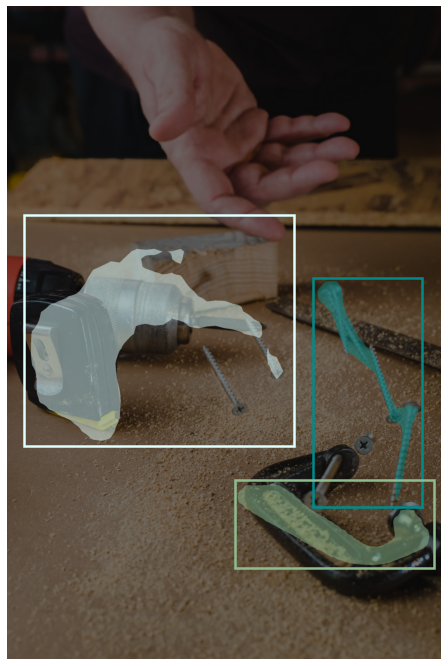

In [ ]:
%matplotlib inline

boxes = boxes_list[0]
masks = prediction_function(tf.convert_to_tensor(image),
                                                                                                                                                                                                                                tf.convert_to_tensor(boxes, dtype=tf.float32))
plot_image_annotations(image, boxes, masks.numpy())
plt.show()